### Light curve calculation
binned in runs, or in nights

In [7]:
import numpy as np
import pickle
import mysql.connector
import matplotlib.pyplot as plt
import pandas as pd
import pymysql
import os
from matplotlib.offsetbox import AnchoredText

In [8]:
def query(command):
    conn = mysql.connector.connect(user='factdata',password='40drs4320Bias',host='ihp-pc45.ethz.ch',database='factdata',port='3306')
    cursor = conn.cursor()    
    result = pd.read_sql_query(command, conn)
    conn.close()
    return result

In [9]:
cmd = '''
SELECT
   Images.*,
   Position.X,
   Position.Y
FROM
   Images
LEFT JOIN Position USING (FileId, EvtNumber)
LEFT JOIN RunInfo  USING (FileId)
WHERE
   fSourceKey=7
AND
   fRunTypeKey=1
AND
   FileId BETWEEN 160601000 AND 160615000
AND
   fR750Cor>0.9*fR750Ref
AND
   NumUsedPixels>5.5
AND
   NumIslands<3.5
AND
   Leakage1<0.1
AND
   Width*Length*PI() < LOG10(Size)*898-1535
'''
data = query(cmd)

In [10]:
# useful values
mm2deg = 0.0117193246260285378
# Create bins for the histogram
bins_number = 30
bins = np.linspace(0,0.3,bins_number+1)
ratio_on_off = 1/5 # ratio between on and off regions

In [11]:
# transforming the column names into arrays with the name of the column and with its values
for par in list(data.columns):
    vars()[par] = data[f'{par}'].values

In [12]:
# First calculate all cuts to speedup the analysis
area =  np.pi*Width*Length
    
non = np.zeros((len(FileId)))
noff = np.zeros((5, len(FileId)))

# Loop over all wobble positions in the camera
for k, angle in enumerate(range(0,360,60)):

    # ----------- Source dependent parameter calculation ----------
    cr = np.cos(np.deg2rad(angle))
    sr = np.sin(np.deg2rad(angle))

    # the position of the source in each wobble position
    px = cr*X-sr*Y 
    py = cr*Y+sr*X  

    # distance of the center of gravity to the source center in each wobble position
    dx = MeanX-px*1.02  
    dy = MeanY-py*1.02

    norm = np.sqrt(dx*dx+dy*dy)
    dist = norm*mm2deg

    # these are unitary vectors in the ellipse frame, lx and ly are alligned with the short and long ellipse axes
    lx = np.minimum(np.maximum((CosDelta*dy-SinDelta*dx)/norm,(-1*np.ones(area.shape))),np.ones(area.shape))
    ly = np.minimum(np.maximum((CosDelta*dx+SinDelta*dy)/norm,(-1*np.ones(area.shape))),np.ones(area.shape))

    alpha = np.arcsin(lx)
    sgn = np.sign(ly)

    # ------------------------ Application ---------------------
    # both help to say from which of the two solutions for disp i should use
    m3l = M3Long*sgn*mm2deg
    slope = SlopeLong*sgn/mm2deg

    # -------------------------- Analysis ----------------------
    xi = 1.39252+0.154247*slope+1.67972*(1-1/(1+4.86232*Leakage1))

    sign1 = m3l+0.07
    sign2 = (dist-0.5)*7.2-slope

    xi_final = xi.copy()
    for i, is_negative in enumerate((sign1<0) | (sign2<0)):
        if is_negative:
            xi_final[i] = -xi_final[i]

    disp = xi_final*(1-Width/Length)

    # this is the formula c^2 = a^2 + b^2 - 2ab*cos alpha , cos² alpha + sin² = 1
    # in this case dist = distance of the ellipse center to the pointing 
    thetasq = disp*disp+dist*dist-2*disp*dist*np.sqrt(1-lx*lx)
    
    if angle == 0:
        non = thetasq
    else:
        noff[k-1] = thetasq

In [16]:
dates_array = (FileId / 1000).astype(int)
dates_unique = np.unique(dates_array)

In [17]:
def plotting(non_binning, noff_binning, title):
    plt.hist(bins[:-1], bins=bins,histtype='step', weights=non_binning, label='ON')
    plt.hist(bins[:-1], bins=bins,histtype='step', weights=ratio_on_off*noff_binning, label='OFF')
    plt.title(f'{title}')
    plt.grid(alpha=0.25)
    plt.xlabel(r'$\theta^{2} [deg^{2}]$')
    plt.ylabel('Events counts')
    plt.legend()
    plt.show()
    return

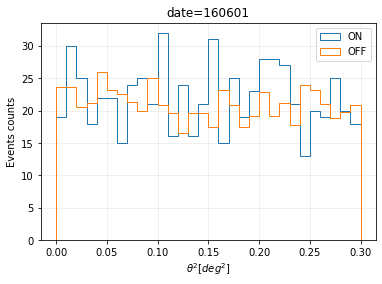

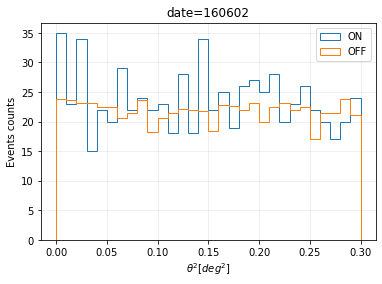

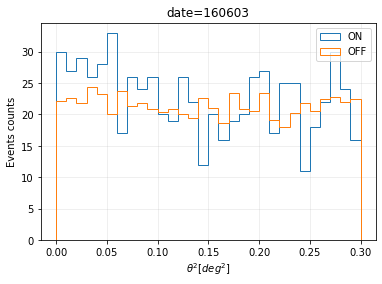

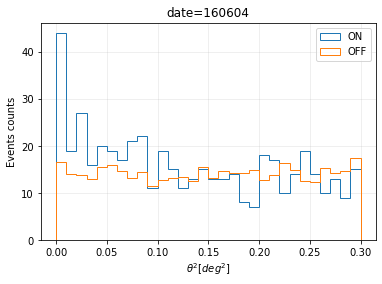

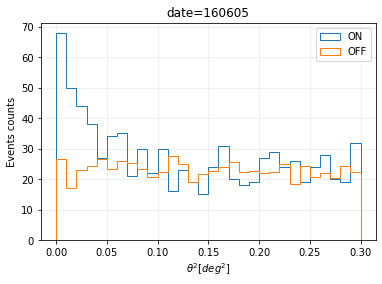

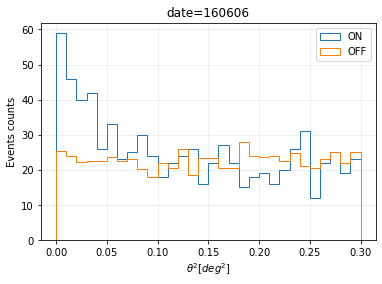

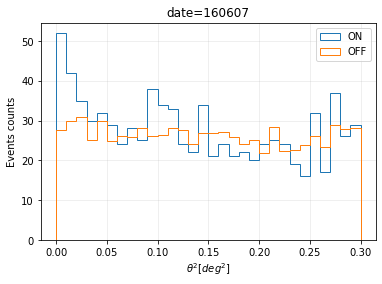

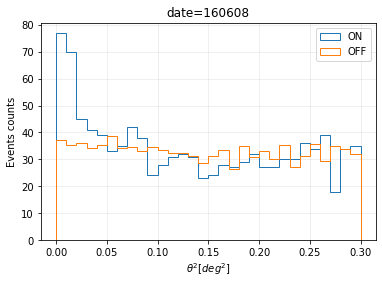

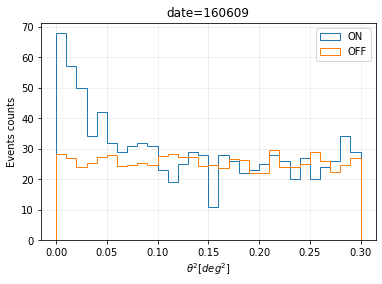

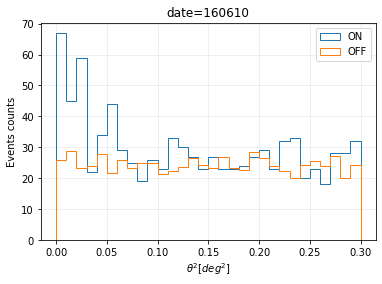

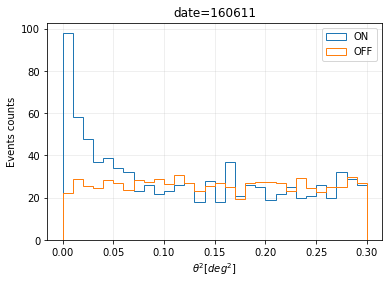

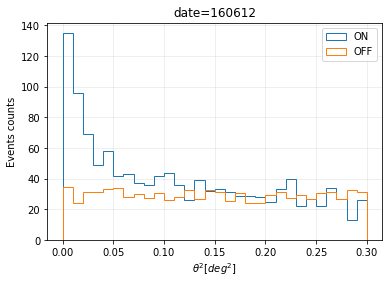

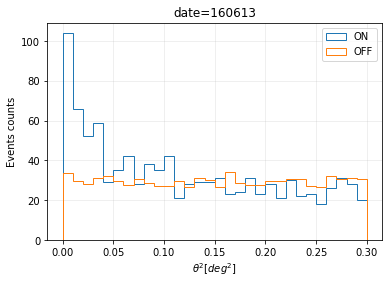

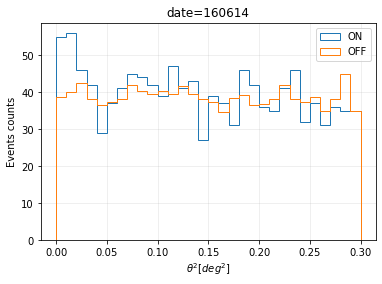

In [18]:
for date in dates_unique:
    mask = (dates_array == date)
    noff_hist = np.histogram(noff[:,mask].ravel(), bins=bins)
    non_hist = np.histogram(non[mask], bins=bins)
    plotting(non_hist[0], noff_hist[0], f'date={date}')

In [19]:
# let's say i apply the same theta2 cut for all the days
cut_theta2 = 0.04
mask_theta2 = bins < cut_theta2

In [20]:
excess_total = np.zeros(len(dates_unique))

for i, date in enumerate(dates_unique):
    mask = (dates_array == date)
    noff_hist = np.histogram(noff[:,mask].ravel(), bins=bins)
    non_hist = np.histogram(non[mask], bins=bins)
    
    # summing the counts that survived the cut in theta2
    N_on = np.sum(non_hist[0][mask_theta2[:-1]])
    N_off = np.sum(ratio_on_off*noff_hist[0][mask_theta2[:-1]])
    
    # excess
    excess_total[i] = N_on - N_off

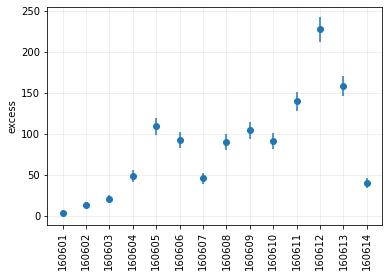

In [19]:
plt.errorbar(dates_unique.astype(str), excess_total, yerr=np.sqrt(excess_total), ls='none', marker='o')
plt.xticks(dates_unique.astype(str), dates_unique.astype(str), rotation='vertical');
plt.ylabel('excess')
plt.grid(alpha=0.25)

The plot above shows the total excess of the night. <br>
It can happen that one night has more runs than others. <br>
For a fair comparison, we can plot the excess while considering how many hours of observation were taken into account.

In [21]:
# what are the runs we have in this data?
runs_unique = np.unique(FileId, return_index=True, return_inverse=True, return_counts=True)

In [22]:
runs_pernight = np.unique((runs_unique[0]/1000).astype(int), return_index=True, return_inverse=True, return_counts=True)

In [23]:
# it shows me how many nights we have
runs_pernight[0]

array([160601, 160602, 160603, 160604, 160605, 160606, 160607, 160608,
       160609, 160610, 160611, 160612, 160613, 160614])

In [24]:
# it shows me how many runs per night we have
runs_pernight[3]

array([37, 40, 35, 29, 35, 42, 38, 42, 39, 37, 39, 44, 44, 46])

In [25]:
# Each run has 5 mins duration, but i want it in hours
excess_night_perhour = excess_total/(runs_pernight[3]*5/60)

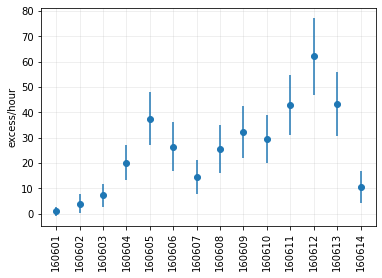

In [26]:
# plt.errorbar(dates_unique.astype(str), excess_total, yerr=np.sqrt(excess_total), ls='none', marker='o')
plt.errorbar(dates_unique.astype(str), excess_night_perhour, yerr=np.sqrt(excess_total), ls='none', marker='o')
plt.xticks(dates_unique.astype(str), dates_unique.astype(str), rotation='vertical');
plt.ylabel('excess/hour')
plt.grid(alpha=0.25)

Now we can to take a closer look into the 12th night, so we do a finer binning, precisely runwise. 

In [27]:
selected_date = 160612
runs_in_selected_date = ((runs_unique[0]/1000).astype(int) == selected_date)
runs_in_selected_date = runs_unique[0][runs_in_selected_date]

In [28]:
excess_total = np.zeros(len(runs_in_selected_date))
for i, run in enumerate(runs_in_selected_date):
    mask = FileId == run
    noff_hist = np.histogram(noff[:,mask].ravel(), bins=bins)
    non_hist = np.histogram(non[mask], bins=bins)
    
    # summing the counts that survived the cut in theta2
    N_on = np.sum(non_hist[0][mask_theta2[:-1]])
    N_off = np.sum(ratio_on_off*noff_hist[0][mask_theta2[:-1]])
    
    # excess
    excess_total[i] = N_on-N_off

/Users/ayusafzai/opt/anaconda3/envs/gammainclass/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Excess plot per run')

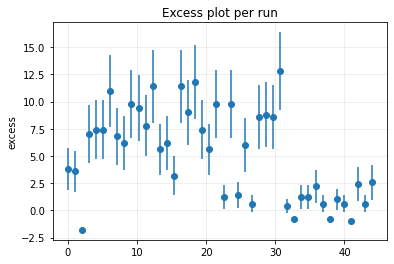

In [29]:
plt.errorbar(np.linspace(0,len(runs_in_selected_date),len(runs_in_selected_date)), excess_total, yerr=np.sqrt(excess_total), ls='none', marker='o')
plt.ylabel('excess')
plt.grid(alpha=0.25)
plt.title('Excess plot per run')

With too fine binning it is hard to see something or understand what is happening, therefore a bigger bin is necessary to compensate the lack of statistics

In [34]:
# I want to merge every 4 runs, meaning 20 min

group_n_runs = 4
excess_grouped_runs = np.sum(excess_total.reshape(-1,group_n_runs), axis=1)

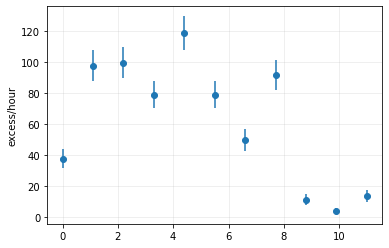

In [35]:
#this is a conversion from runs to excess counts per hour

factor = 60/(5*group_n_runs) #60 min/group run min

plt.errorbar(np.linspace(0,len(excess_grouped_runs),len(excess_grouped_runs)), factor*excess_grouped_runs, yerr=np.sqrt(factor*excess_grouped_runs), ls='none', marker='o')
plt.ylabel('excess/hour')
plt.grid(alpha=0.25)

## better to change this x-label to mjd